# Importing necessary packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

# Generating data 


## Function to be fitted

In [2]:
def function(x):
  y1 = np.sin(.5*x)
  y2 = np.cos(.8*x)
  y3 = np.tanh(.8*x)
  #y =1e3*((y1 + y2 + y3)*y1+.001*x**2+1e-4*x)
  y = 1e3*(0.01*x**2+np.sin(x*np.sin(.5*x)))
  return y
vf = np.vectorize(function)

### Plot the function

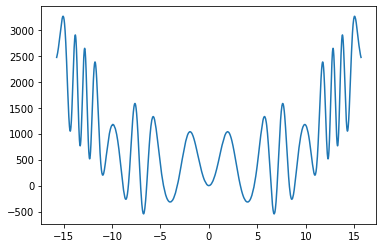

In [3]:
init = -5*np.pi
endval = 5*np.pi
step = .0003
x = np.arange(init,endval+step,step)
y = vf(x) + .1*np.random.rand(np.size(x))
plt.plot(x,y)

## Randomizing and divinding data into test and train sets

In [4]:
p = np.random.permutation(len(x)) # Create a random permutation 
x_perm = x[p]
y_perm = y[p] # Aplling same permutation on both

### Plotting to see if nothing changed (sceptical people go :D )

In [5]:
#plt.plot(x,y)
#plt.plot(x_perm,y_perm,',r')

### Train set and test set, train set is 80% of the data

In [6]:
x_train_full , x_test , y_train_full, y_test = x_perm[:int(np.floor(.8*len(x)))], x_perm[int(np.floor(.8*len(x))):], y_perm[:int(np.floor(.8*len(x)))], y_perm[int(np.floor(.8*len(x))):]

#### Since all the training data is mixed the plot is the same (except for the blank spots)

In [7]:
#plt.plot(x_train_full,y_train_full,',r')

In [8]:
#plt.plot(x_test,y_test,',b')

### Validation and training set

In [9]:
x_train, x_valid, y_train, y_valid = x_train_full[:int(np.floor(.8*len(x_train_full)))], x_train_full[int(np.floor(.8*len(x_train_full))):], y_train_full[:int(np.floor(.8*len(x_train_full)))], y_train_full[int(np.floor(.8*len(x_train_full))):]

In [10]:
#plt.plot(x_train,y_train,',r')

# Scaling the data

In [11]:
scaler_in = MinMaxScaler()
scaler_out = MinMaxScaler()
x_train = scaler_in.fit_transform(x_train.reshape(-1,1)).reshape(-1)# fit minMax scaler and scale, reshape to go to a 2D array and reshape it back to 1D
y_train = scaler_out.fit_transform(y_train.reshape(-1,1)).reshape(-1)
x_valid = scaler_in.transform(x_valid.reshape(-1,1)).reshape(-1) # scale
y_valid = scaler_out.transform(y_valid.reshape(-1,1)).reshape(-1)
#### Scaling test data
x_test = scaler_in.transform(x_test.reshape(-1,1)).reshape(-1)
y_test = scaler_out.transform(y_test.reshape(-1,1)).reshape(-1)


# Making the DNN 

#### Using keras functional api to construct the the  problem
#### Using wide and deep neural net

In [12]:
input_ = keras.layers.Input(shape=(1,))
#### Increasing dimensions to 100 with 2 layers
hidden_1 = keras.layers.Dense(100, activation="tanh")(input_)
hidden_2 = keras.layers.Dense(100, activation="tanh")(hidden_1)
#### Creating encoder_decoder directly
enc_1 = keras.layers.Dense(100,activation="tanh")(hidden_2)
enc_2 = keras.layers.Dense(50,activation="tanh")(enc_1)
enc_3 = keras.layers.Dense(30,activation="tanh")(enc_2)
enc_4 = keras.layers.Dense(10,activation="tanh")(enc_3) ## End of encoder
dec_1 = keras.layers.Dense(30,activation="tanh")(enc_4)
dec_2 = keras.layers.Dense(50,activation="tanh")(dec_1)
dec_3 = keras.layers.Dense(100,activation="tanh")(dec_2)
out_dec = keras.layers.Dense(1,name="decoder_output")(dec_3) ## Output of decoder
#### Creating recon DNN on 10 dimensional encoder outputs
outer_layers = 6
hidden_y = keras.layers.Concatenate()([enc_4,input_])
hidden_y = keras.layers.Dense(10, activation="tanh")(hidden_y)
for e_layer in range (outer_layers):
    hidden_x = keras.layers.Dense(10, activation="tanh")(hidden_y)
    #hidden_x = keras.layers.Dropout(rate=0.1)(hidden_x)
    inner_layers = 2
    for layer in range(inner_layers-1):
        hidden_x = keras.layers.Dense(5, activation="tanh")(hidden_x)
        #hidden_x = keras.layers.Dropout(rate=0.1)(hidden_x)
    concat = keras.layers.Concatenate()([hidden_y,hidden_x])
    hidden_y = keras.layers.Dense(15,activation="tanh")(concat)
hidden_out_1 = keras.layers.Dense(10, activation="tanh")(hidden_y)
output = keras.layers.Dense(1,name="main_output")(hidden_out_1)
model = keras.Model(inputs=[input_], outputs=[output,out_dec])

## Compiling the DNN

In [13]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.7, patience=5, verbose=1, min_lr=0.0001)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, restore_best_weights=True)
model.compile(loss=["mse", "mse"], loss_weights=[0.9,0.1], optimizer=keras.optimizers.Nadam(lr=0.001))

## Seeing the DNN 

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          200         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          10100       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 100)          10100       dense_1[0][0]                    
______________________________________________________________________________________________

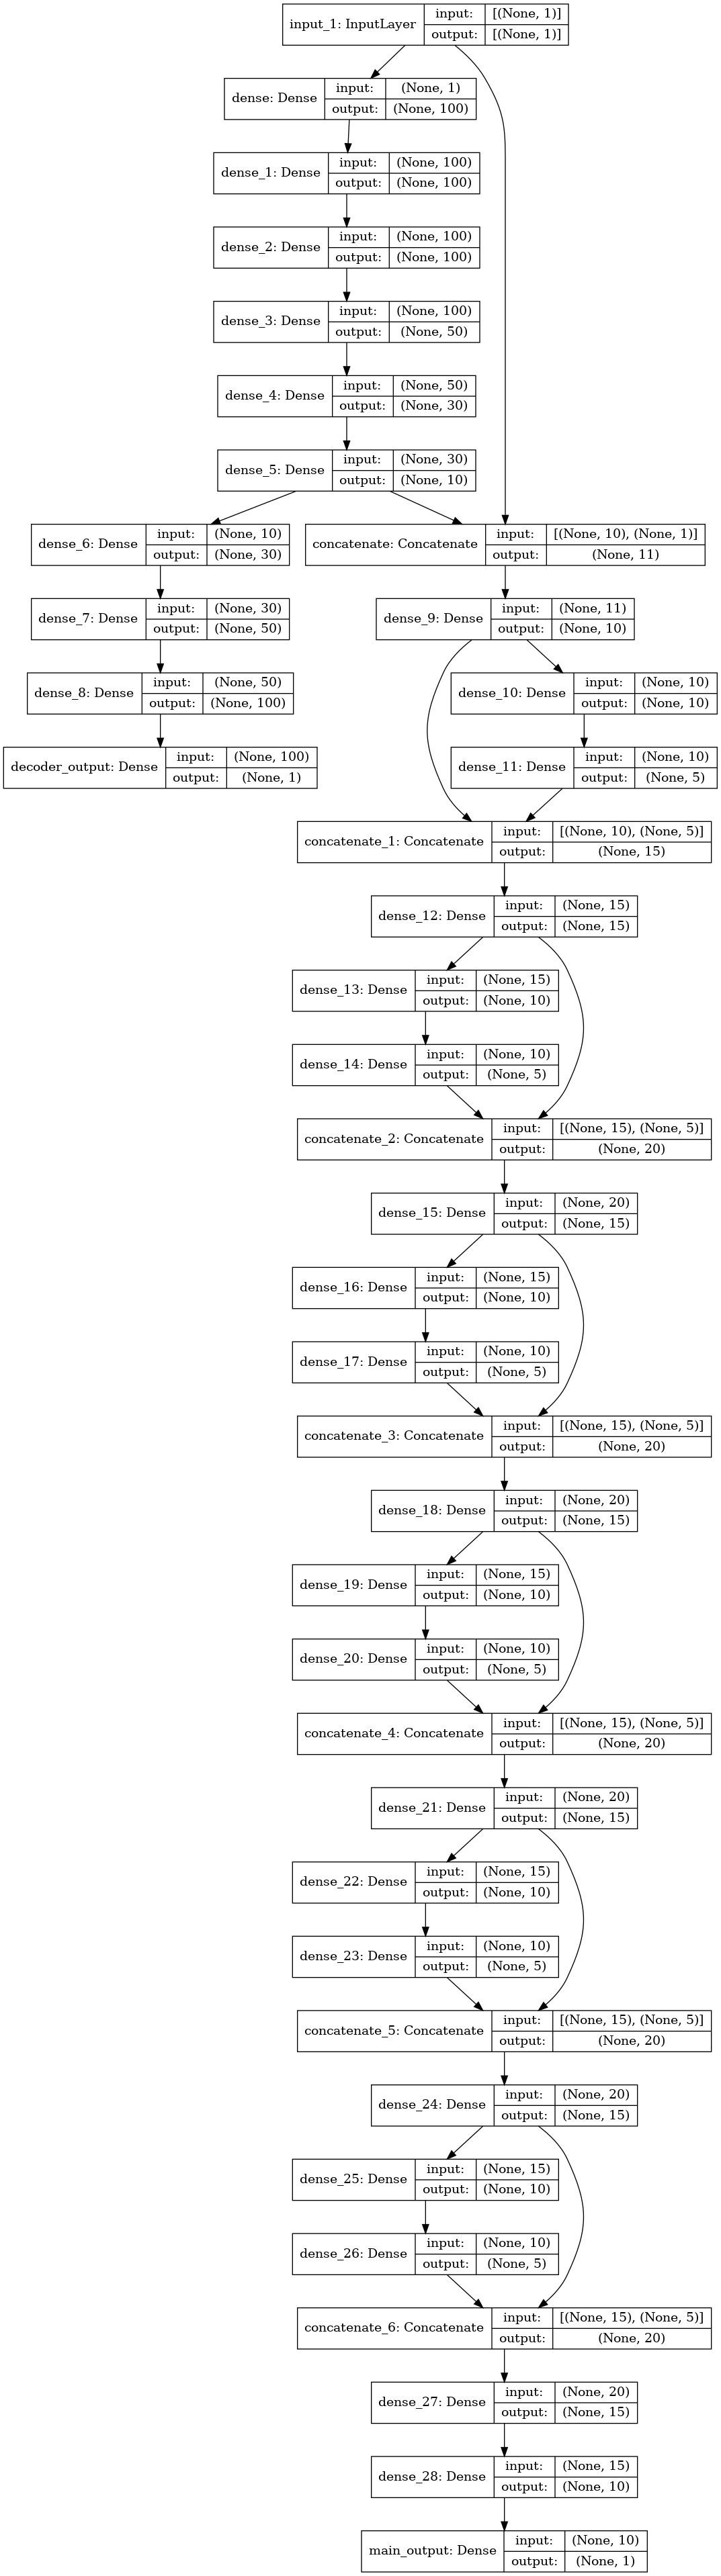

In [15]:
keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Fitting the DNN

In [16]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
  print('Found GPU at: {}'.format(device_name))
  with tf.device(device_name):
    history = model.fit(x_train,y_train, epochs=30, validation_data=(x_valid,y_valid))
else:
  history = model.fit(x_train,[y_train,x_train], epochs=300, validation_data=(x_valid,[y_valid,x_valid]),callbacks=[lr_scheduler,early_stop])

tep - loss: 2.2917e-05 - main_output_loss: 2.4912e-05 - decoder_output_loss: 4.9593e-06 - val_loss: 1.0057e-05 - val_main_output_loss: 1.0915e-05 - val_decoder_output_loss: 2.3327e-06
Epoch 87/300
2095/2095 [==============================] - 3s 2ms/step - loss: 1.9659e-05 - main_output_loss: 2.1294e-05 - decoder_output_loss: 4.9442e-06 - val_loss: 2.8386e-06 - val_main_output_loss: 2.9011e-06 - val_decoder_output_loss: 2.2763e-06
Epoch 88/300
2095/2095 [==============================] - 3s 2ms/step - loss: 1.4800e-05 - main_output_loss: 1.6027e-05 - decoder_output_loss: 3.7497e-06 - val_loss: 6.1592e-06 - val_main_output_loss: 6.4371e-06 - val_decoder_output_loss: 3.6583e-06
Epoch 89/300
2095/2095 [==============================] - 3s 2ms/step - loss: 1.9270e-05 - main_output_loss: 2.0918e-05 - decoder_output_loss: 4.4457e-06 - val_loss: 1.1943e-05 - val_main_output_loss: 1.2827e-05 - val_decoder_output_loss: 3.9919e-06
Epoch 90/300
2095/2095 [==============================] - 3s 2ms/s

In [17]:
mse_test = model.evaluate(x_test, [y_test,x_test])

655/655 [==============================] - 0s 606us/step - loss: 2.1254e-05 - main_output_loss: 2.3416e-05 - decoder_output_loss: 1.7984e-06


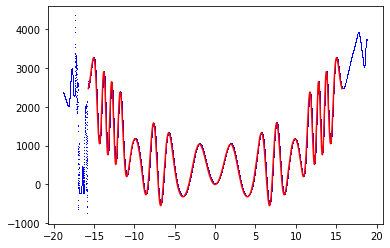

In [19]:
x_new_unscaled = np.arange(-6*np.pi,6*np.pi+step*10,step*10)
x_new = scaler_in.transform(x_new_unscaled.reshape(-1,1)).reshape(-1) # scale data to predict with the same transformation
y_new,x_decoder = model.predict(x_new) # make prediction
y_new_unscaled = scaler_out.inverse_transform(y_new.reshape(-1,1)).reshape(-1) # back to the original scale
x_decoder_uns = scaler_in.inverse_transform(x_decoder.reshape(-1,1)).reshape(-1) # back to the original scale
plt.plot(x_new_unscaled,y_new_unscaled,',b')
plt.plot(x,y,'r')
#plt.plot(x_decoder_uns,vf(x_decoder_uns),'g')